# Regression: Predict fuel efficiency

In [1]:
# Use seaborn for pairplot
!pip install seaborn

# Use some functions from tensorflow_docs
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-nupayxwp
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-nupayxwp
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0-cp36-none-any.whl size=80547 sha256=2c5e1d97c6d9506bf64a0633e316e3d5b801deeed50c6a998d1e52a4b6b9bce9
  Stored in directory: /tmp/pip-ephem-wheel-cache-paxyl2q0/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

TensorFlow 2.x selected.
2.0.0


In [0]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

## The Auto MPG dataset



### Get the data

In [5]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

32768/30286 [================================] - 0s 1us/step


'/root/.keras/datasets/auto-mpg.data'

Import it using pandas

In [6]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### Clean the data

In [7]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [0]:
dataset = dataset.dropna()

In [0]:
dataset['Origin'] = dataset['Origin'].map(lambda x: {1: 'USA', 2: 'Europe', 3: 'Japan'}.get(x))

In [10]:
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


### Split the data into train and test

In [0]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Inspect the data

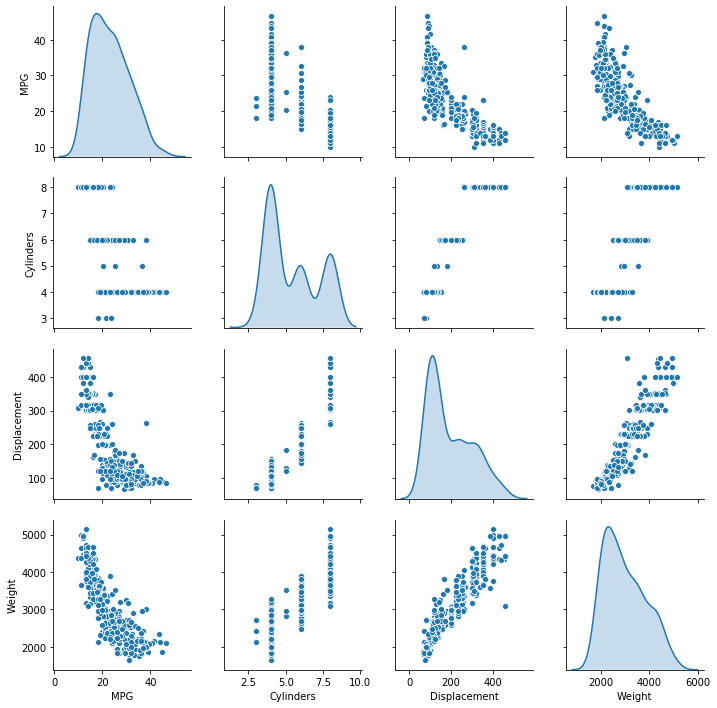

In [12]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

Also look at the overall statistics:

In [13]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


### Split features from labels

In [0]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

### Normalize the data

In [0]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

## The model

### Build the model

In [0]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [0]:
model = build_model()

### Inspect the model

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [19]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.1424214 ],
       [-0.03688651],
       [-0.28703812],
       [-0.15832561],
       [-0.35632426],
       [-0.05860433],
       [-0.32426053],
       [-0.41555804],
       [-0.11767273],
       [-0.52941895]], dtype=float32)

### Train the model

In [20]:
EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:579.8030,  mae:22.8133,  mse:579.8031,  val_loss:571.6579,  val_mae:22.5842,  val_mse:571.6578,  
....................................................................................................
Epoch: 100, loss:6.0092,  mae:1.6938,  mse:6.0092,  val_loss:7.9457,  val_mae:2.1550,  val_mse:7.9457,  
....................................................................................................
Epoch: 200, loss:5.0640,  mae:1.5339,  mse:5.0640,  val_loss:8.3142,  val_mae:2.1902,  val_mse:8.3142,  
....................................................................................................
Epoch: 300, loss:4.7548,  mae:1.4735,  mse:4.7548,  val_loss:8.3894,  val_mae:2.1166,  val_mse:8.3894,  
....................................................................................................
Epoch: 400, loss:4.2477,  mae:1.3886,  mse:4.2477,  val_loss:9.2791,  val_mae:2.2711,  val_mse:9.2791,  
..............................................................

In [21]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.402975,0.979613,2.402975,10.565269,2.450993,10.565269,995
996,2.566106,1.039499,2.566106,10.637815,2.437782,10.637815,996
997,2.670943,1.066217,2.670943,10.949621,2.563398,10.949622,997
998,2.718776,1.076825,2.718776,11.054992,2.562296,11.054992,998
999,2.646638,1.040887,2.646638,10.438986,2.451207,10.438986,999


In [0]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'MAE [MPG]')

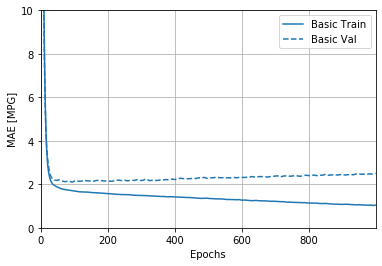

In [23]:
plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

Text(0, 0.5, 'MSE [MPG^2]')

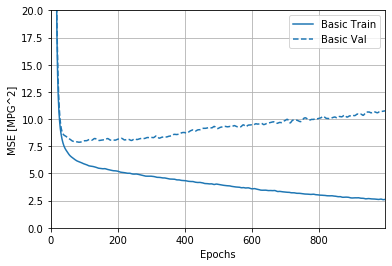

In [24]:
plotter.plot({'Basic': history}, metric = "mse")
plt.ylim([0, 20])
plt.ylabel('MSE [MPG^2]')

In [25]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(normed_train_data, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:557.9222,  mae:22.4116,  mse:557.9222,  val_loss:547.8256,  val_mae:22.1899,  val_mse:547.8256,  
....................................................................

Text(0, 0.5, 'MAE [MPG]')

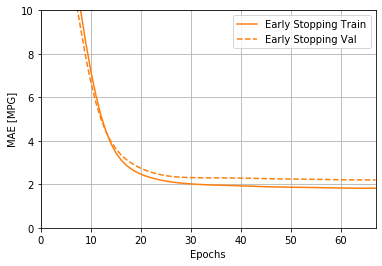

In [26]:
plotter.plot({'Early Stopping': early_history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

In [27]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

78/78 - 0s - loss: 5.5181 - mae: 1.8396 - mse: 5.5181
Testing set Mean Abs Error:  1.84 MPG


### Make predictions

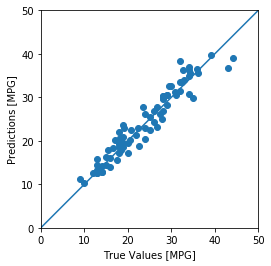

In [28]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


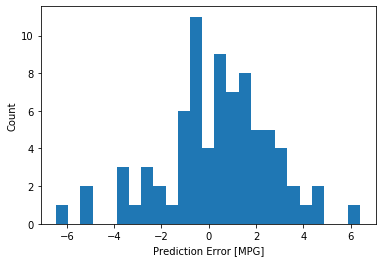

In [29]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")